In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import time
import json

from IPython import display

In [2]:
BATCH_SIZE = 32
MAP_SIZE = 32
LR_D = LR_G = 0.00005

In [3]:
rm -rf sample_data/

In [4]:
# TODO: Change path here if different
train_images_path = 'smb1_str_right.json'
train_images_cond_path = 'smb1_left.json'
train_images = np.array(json.load(open(train_images_path)))
train_images_cond = np.array(json.load(open(train_images_cond_path)))
print(train_images.shape)
print(train_images_cond.shape)

(2518, 14, 28)
(2518, 14, 28)


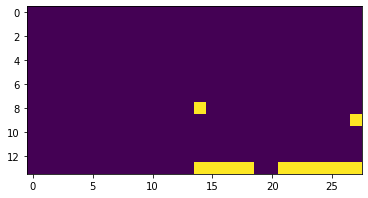

In [5]:
plt.imshow(train_images[50])

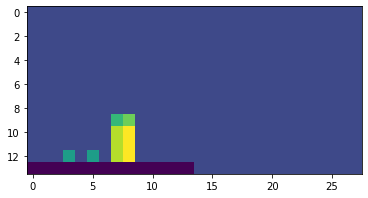

In [6]:
plt.imshow(train_images_cond[50])

In [7]:
train_size, x_dims, y_dims = train_images.shape
z_dims = np.amax(train_images) + np.amax(train_images_cond) + 2
cond_dims = np.amax(train_images_cond) + 1

print(train_size, x_dims, y_dims, z_dims)

def get_processed_images(images, encoding_index=2):
  train_size, x_dims, y_dims = images.shape
  z_dims = np.amax(images) + 1 # Number of different title types

  images_onehot = np.eye(z_dims, dtype='uint8')[images]
  print(images_onehot.shape) # (train_size, x_dims, y_dims, z_dims)

  images = np.zeros((train_size, MAP_SIZE, MAP_SIZE, z_dims))
  print(images.shape)

  images[:, :, :, encoding_index] = 1.0  # Fill with empty space 

  images[:train_size, :x_dims, :y_dims, :] = images_onehot
  print(images.shape)

  return images

# TODO: Change empty space encoding here if different
train_images = get_processed_images(train_images, 0)
train_images_cond = get_processed_images(train_images_cond)

2518 14 28 15
(2518, 14, 28, 2)
(2518, 32, 32, 2)
(2518, 32, 32, 2)
(2518, 14, 28, 13)
(2518, 32, 32, 13)
(2518, 32, 32, 13)


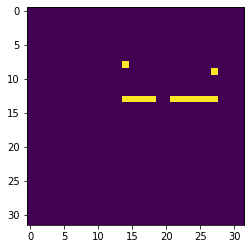

In [8]:
plt.imshow(np.argmax(train_images[50], axis=2))

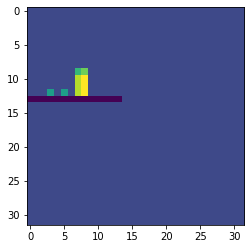

In [9]:
plt.imshow(np.argmax(train_images_cond[50], axis=2))

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_images_cond)).shuffle(train_size).batch(BATCH_SIZE)

In [11]:
train_dataset

<BatchDataset shapes: ((None, 32, 32, 2), (None, 32, 32, 13)), types: (tf.float64, tf.float64)>

In [12]:
def make_discriminator_model(n_extra_layers=0):
  assert MAP_SIZE % 16 == 0

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, input_shape=(MAP_SIZE, MAP_SIZE, z_dims)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))

  image_size, n_filters = MAP_SIZE / 2, 64

  # Extra layers
  for i in range(n_extra_layers):
    model.add(layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

  while image_size > 4:
    n_filters *= 2
    model.add(layers.Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    image_size /= 2

  # Input here is (BATCH_SIZE x 4 x 4 x n_filters)
  model.add(layers.Conv2D(1, (4, 4), strides=(1, 1), padding='valid', use_bias=False))
    
  return model

In [13]:
def make_generator_model(n_extra_layers=0):
  assert MAP_SIZE % 16 == 0

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, input_shape=(MAP_SIZE, MAP_SIZE, cond_dims)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  image_size, n_filters = MAP_SIZE / 2, 64

  # Extra layers
  for i in range(n_extra_layers):
    model.add(layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

  while image_size > 4:
    n_filters *= 2
    model.add(layers.Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    image_size /= 2

  noise_size = 32
  # 32 here is the 1/2 * n_channels before last Conv2DTranspose
  image_size, n_filters = 4, 32 * MAP_SIZE / 4

  model_noise = tf.keras.Sequential()
  model_noise.add(tf.keras.Input(shape=(noise_size, )))
  model_noise.add(layers.Reshape((1, 1, noise_size)))
  
  model_noise.add(layers.Conv2DTranspose(n_filters, (4, 4), strides=(1, 1), padding='valid', use_bias=False))
  model_noise.add(layers.BatchNormalization())
  model_noise.add(layers.ReLU())

  merged_layers = layers.concatenate([model.output, model_noise.output])
  
  x = layers.Conv2DTranspose(n_filters, (4, 4), strides=(1, 1), padding='same', use_bias=False)(merged_layers)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  while image_size < MAP_SIZE / 2:
    n_filters /= 2
    x = layers.Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    image_size *= 2

  # Extra layers
  for i in range(n_extra_layers):
    x = layers.Conv2DTranspose(n_filters, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(z_dims - cond_dims, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
  out = layers.ReLU()(x)

  final_model = tf.keras.Model([model.input, model_noise.input], [out])
  return final_model

In [14]:
discriminator = make_discriminator_model()
generator = make_generator_model()

In [15]:
print(discriminator.summary())
print(generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        15360     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         5

In [16]:
print(generator([np.random.rand(1, MAP_SIZE, MAP_SIZE, cond_dims), np.random.rand(1, 32)]).shape)
print(discriminator(np.random.rand(1, MAP_SIZE, MAP_SIZE, z_dims)).shape)

(1, 32, 32, 2)
(1, 1, 1, 1)


In [17]:
def get_discriminator_loss(real_output, generated_output):
  real_loss = tf.reduce_mean(real_output)
  generated_loss = tf.reduce_mean(generated_output)
  total_loss = real_loss - generated_loss

  return total_loss


def get_generator_loss(generated_output):
  return -tf.reduce_mean(generated_output)

In [18]:
discriminator_optimizer = tf.optimizers.RMSprop(LR_D)
generator_optimizer = tf.optimizers.RMSprop(LR_G)

In [19]:
def generate_and_save_images(model, epoch, test_input, savefig=False):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 10))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.argmax(predictions[i], axis=2))
    plt.axis('off')

  if savefig:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [20]:
EPOCHS = 5000
noise_size = 32
num_examples = 16

# Use same random and test vector to see evolution of generated images over time
random_vector_for_generation = tf.random.normal([num_examples, noise_size])
test_vector_for_generation = train_images_cond[50:50 + num_examples, :]

In [21]:
def train_step(images, images_cond, update_generator=False):
  # Generating noise from a normal distribution
  noise = tf.random.normal([images.shape[0], noise_size])
  discriminator_input = tf.concat([images_cond, images], 3)

  for w in discriminator.trainable_variables:
    w.assign(tf.clip_by_value(w, -0.01, 0.01))
    
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator([images_cond, noise], training=True)
    real_output = discriminator(discriminator_input, training=True)
    fake_discriminator_input = tf.concat([tf.cast(images_cond, tf.float32), generated_images], 3)
    generated_output = discriminator(fake_discriminator_input, training=True)

    gen_loss = get_generator_loss(generated_output)
    disc_loss = get_discriminator_loss(real_output, generated_output)
        
    gradients_of_discriminator = disc_tape.gradient(-disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    if update_generator:
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  return gen_loss, disc_loss

In [22]:
def train(dataset, epochs):
  gen_iterations = 0
  for epoch in range(epochs):
    start = time.time()
    disc_iterations = 0
    for i, (images, images_cond) in enumerate(dataset):
      if disc_iterations == 0:
        if gen_iterations < 25 or gen_iterations % 500 == 0:
          disc_iterations = 100
        else:
          disc_iterations = 5
      if disc_iterations == 1 or i == len(dataset) - 1:
        gen_loss, disc_loss = train_step(images, images_cond, True)
        gen_iterations += 1
      else:
        gen_loss, disc_loss = train_step(images, images_cond)
      disc_iterations -= 1

    display.clear_output(wait=True)
    # Save generator every 50 epochs
    if (epoch + 1) % 50 == 0:
      generate_and_save_images(generator, epoch + 1, 
                               [test_vector_for_generation, 
                                random_vector_for_generation], True)
      generator.save('models/generator_structure_combined_' + str(epoch + 1))
    else:
      generate_and_save_images(generator, epoch + 1, 
                               [test_vector_for_generation, 
                                random_vector_for_generation])

    print ('Time taken for epoch {} is {} sec'.format(epoch + 1, 
                                                      time.time() - start))
    print("Generator Loss: ", gen_loss)
    print("Discriminator Loss: ", disc_loss)
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          epochs,
                          [test_vector_for_generation, 
                           random_vector_for_generation])


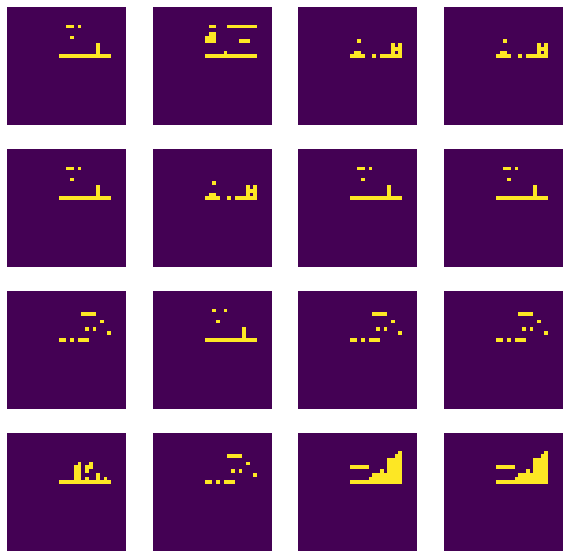

In [23]:
train(train_dataset, EPOCHS)

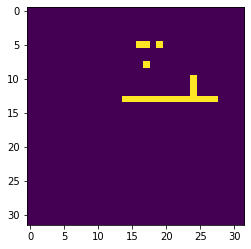

In [25]:
plt.imshow(np.argmax(generator([train_images_cond[50:51], tf.random.normal([1, noise_size])])[0], axis=2))

In [26]:
generator_saved = tf.keras.models.load_model('models/generator_structure_combined_5000')
generator_saved.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_4_input (InputLayer)     [(None, 32, 32, 13)] 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   13312       conv2d_4_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 16, 16, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 16, 64)   0           batch_normalization_3[0][0]      
_______________________________________________________________________________________

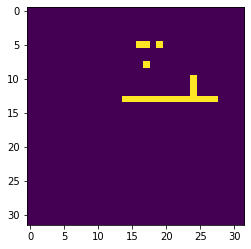

In [27]:
plt.imshow(np.argmax(generator_saved([train_images_cond[50:51], tf.random.normal([1, noise_size])])[0], axis=2))

In [33]:
!zip -r /content/generator_structure_combined_1000.zip /content/models/generator_structure_combined_1000

  adding: content/models/generator_structure_combined_1000/ (stored 0%)
  adding: content/models/generator_structure_combined_1000/variables/ (stored 0%)
  adding: content/models/generator_structure_combined_1000/variables/variables.index (deflated 68%)
  adding: content/models/generator_structure_combined_1000/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/models/generator_structure_combined_1000/assets/ (stored 0%)
  adding: content/models/generator_structure_combined_1000/saved_model.pb (deflated 91%)
